In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## File Descriptions and Data Field Information

### train.csv
- The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- store_nbr identifies the store at which the products are sold.
- family identifies the type of product sold.
- sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

In [2]:
train = pd.read_csv('train.csv', parse_dates=['date'])
train.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object

In [3]:
train.groupby('store_nbr').count().describe()

,id,date,family,sales,onpromotion
count,54.0,54.0,54.0,54.0,54.0
mean,55572.0,55572.0,55572.0,55572.0,55572.0
std,0.0,0.0,0.0,0.0,0.0
min,55572.0,55572.0,55572.0,55572.0,55572.0
25%,55572.0,55572.0,55572.0,55572.0,55572.0
50%,55572.0,55572.0,55572.0,55572.0,55572.0
75%,55572.0,55572.0,55572.0,55572.0,55572.0
max,55572.0,55572.0,55572.0,55572.0,55572.0


### Each store has 55572 entries

In [4]:
train.groupby(['store_nbr', 'family']).count().describe()

,id,date,sales,onpromotion
count,1782.0,1782.0,1782.0,1782.0
mean,1684.0,1684.0,1684.0,1684.0
std,0.0,0.0,0.0,0.0
min,1684.0,1684.0,1684.0,1684.0
25%,1684.0,1684.0,1684.0,1684.0
50%,1684.0,1684.0,1684.0,1684.0
75%,1684.0,1684.0,1684.0,1684.0
max,1684.0,1684.0,1684.0,1684.0


## Total 1782 categories, or need to create 1782 models for each category

In [5]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


### MIssing Days if Any

In [6]:
from datetime import date
import numpy as np

d0 = np.sort(train['date'])[0]
d1 = np.sort(train['date'])[-1]
delta = d1 - d0
no_of_days = train['date'].nunique()
print('The number of days between the given range of dates is :')
print(delta.astype('timedelta64[D]')+1)
print(no_of_days)

The number of days between the given range of dates is :
1688 days
1684


In [7]:
d1

numpy.datetime64('2017-08-15T00:00:00.000000000')

### Find the missing Dates

In [8]:
pd.date_range(start=d0, end=d1).difference(train['date'].unique())

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)

#### Conclusion: In Christmas, stores are always closed 

### Total Sales across Family

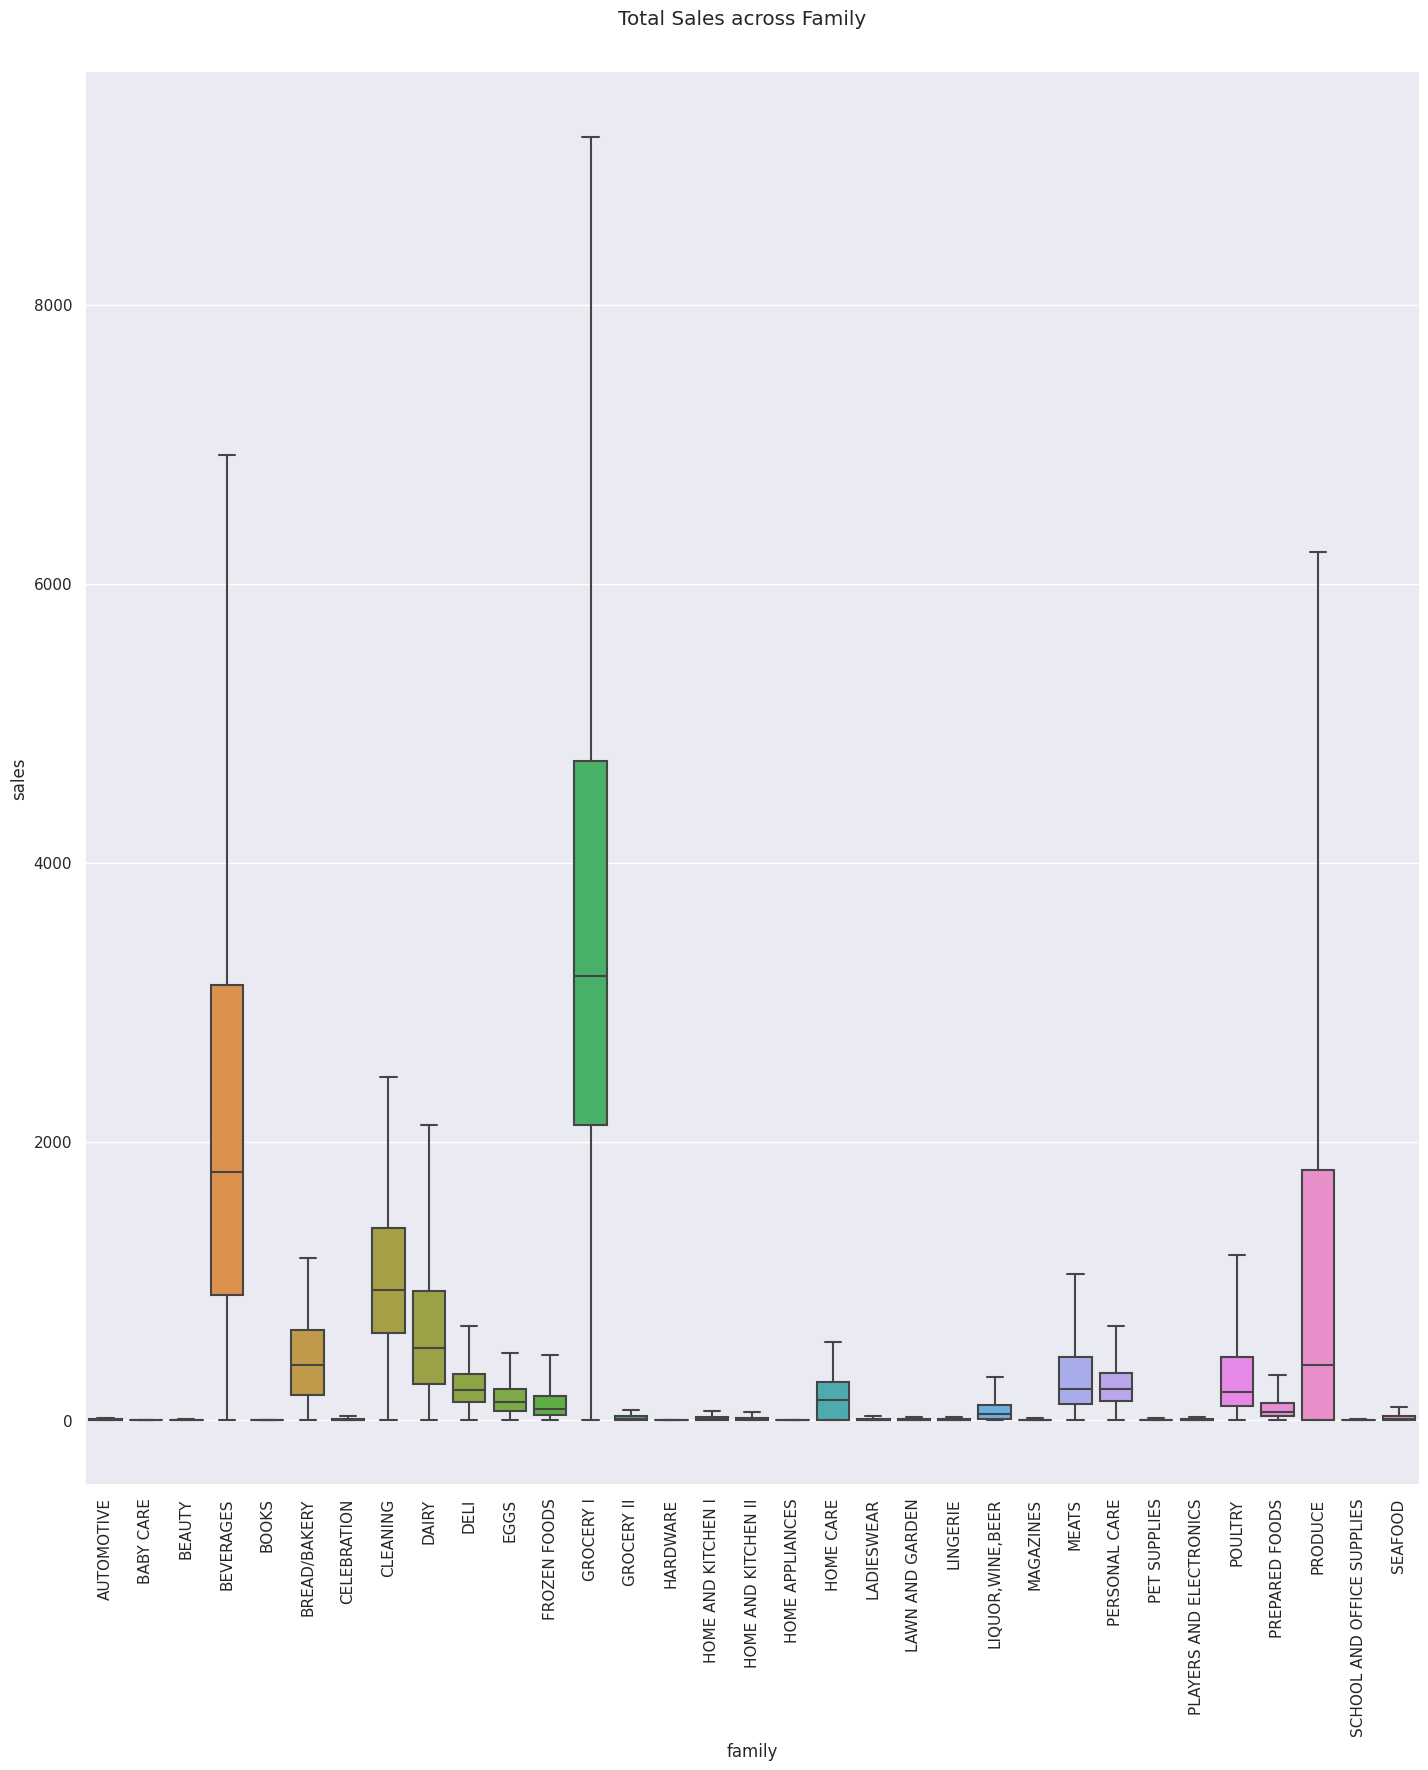

In [9]:
sns.set(rc={'figure.figsize':(20,20)})
g= sns.catplot(data=train, x='family', y='sales', kind='box', whis=[5,95], sym="", height=15, aspect=1/1
            # col=year(date), 
            # col_wrap=3
           )

g.fig.suptitle("Total Sales across Family", y=1.03)
plt.xticks(rotation=90)
plt.show()

### Total Sales across Store Number

In [10]:
print("Total stores are", train['store_nbr'].nunique())

Total stores are 54


In [11]:
# TBD

### Total Sales & Onpromotion

In [12]:
# TBD

### Time Series of Total Sales based on resampling on mean

Text(0.5, 1.03, 'Total Sales across Time')

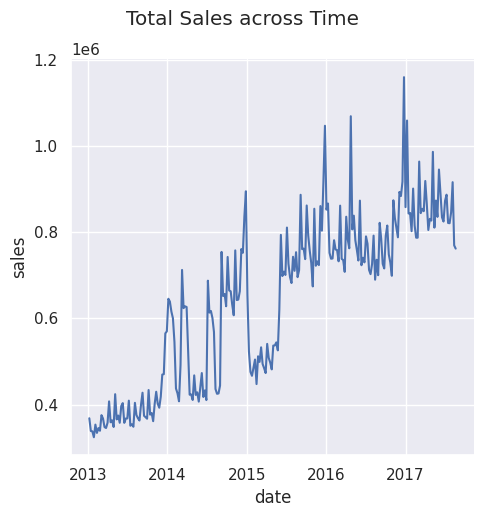

In [13]:
sns.set(rc={'figure.figsize':(12,12)})

resampled_data = train.groupby('date', as_index=False)['sales'].sum().resample('W', on='date').mean()
g = sns.relplot(x="date", y="sales", data=resampled_data, kind="line")

g.fig.suptitle("Total Sales across Time", y=1.03)

Text(0.5, 1.03, 'Total Sales across Time')

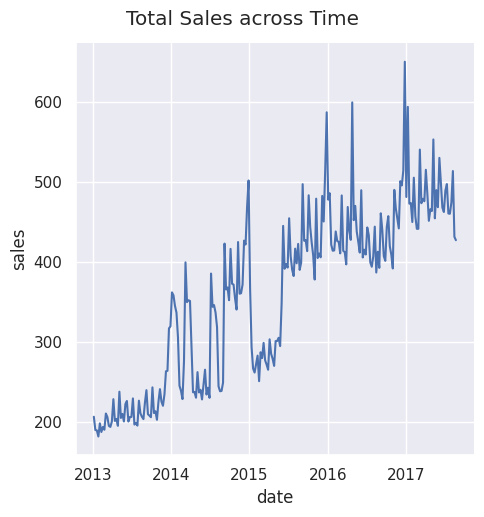

In [14]:
sns.set(rc={'figure.figsize':(12,12)})

resampled_data = train[['date', 'sales']].resample('W', on='date').mean()
g = sns.relplot(x="date", y="sales", data=resampled_data, kind="line")

g.fig.suptitle("Total Sales across Time", y=1.03)

### Singularity for Total Sales

In [15]:
import statsmodels.tsa.stattools as sts
sts.adfuller(train.groupby('date', as_index=False)['sales'].sum()['sales'])

(-2.6161957486048566,
 0.08969592175787472,
 22,
 1661,
 {'1%': -3.4342930672797065,
  '5%': -2.8632816397229064,
  '10%': -2.567697207194407},
 42848.480392783786)

#### Conclusion: Not Stationary but close to stationatity

In [16]:
## TBD

### Seasonality

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [18]:
intermediate = pd.DataFrame(train.groupby('date')['sales'].sum()).asfreq('d')
intermediate.fillna(0, inplace=True)

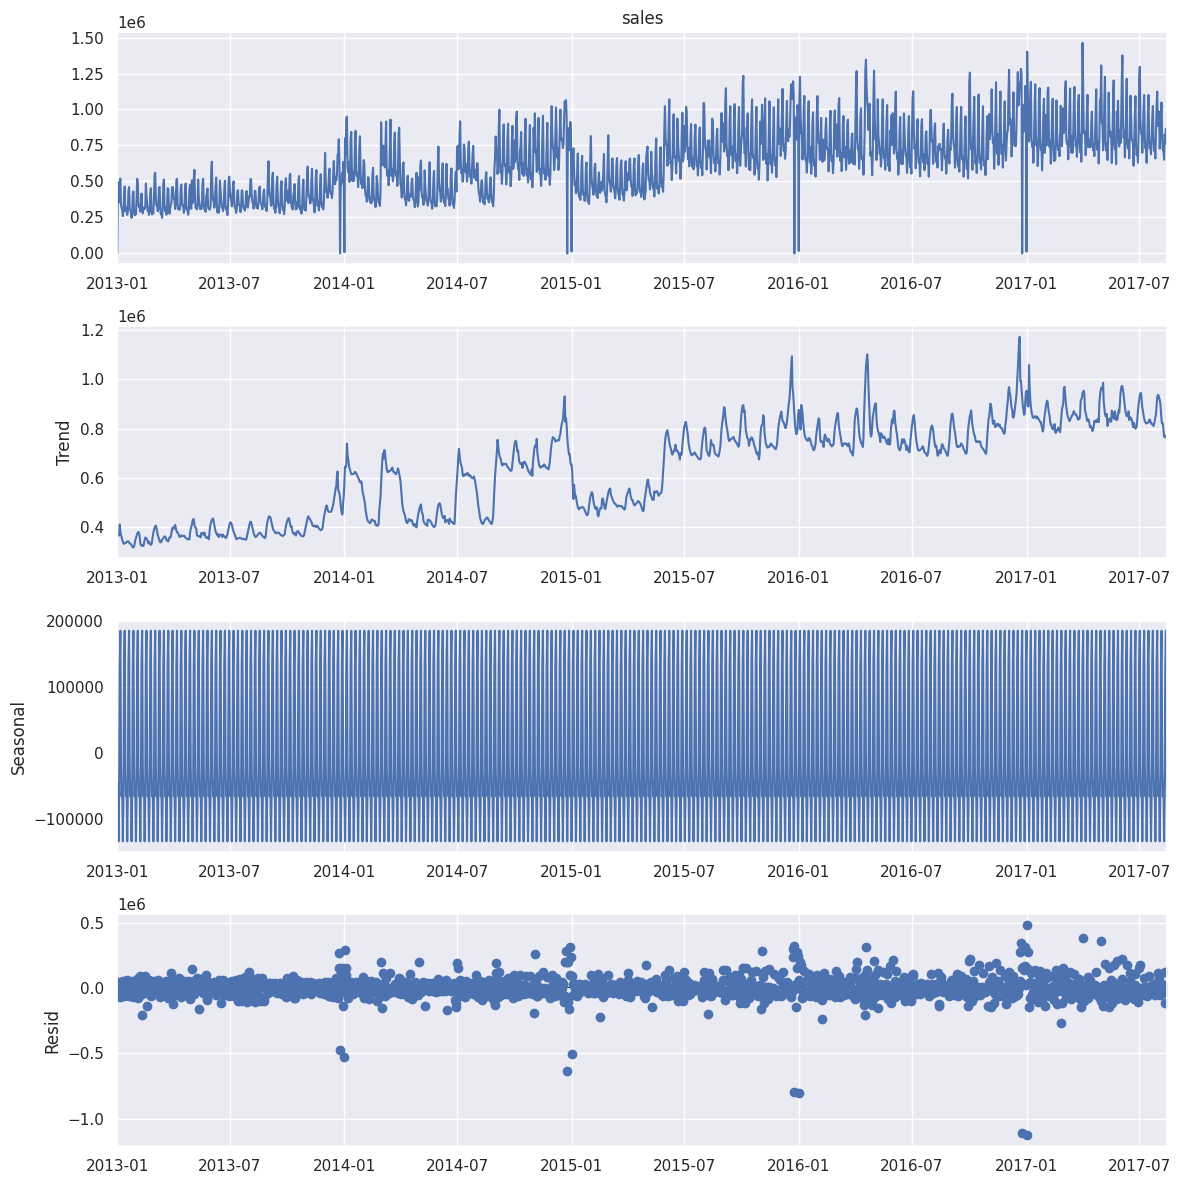

In [19]:
s_dec_additive = seasonal_decompose(intermediate['sales'] , model='additive')
s_dec_additive.plot()
plt.show()

### ACF & PACF of Total Sales Time Series

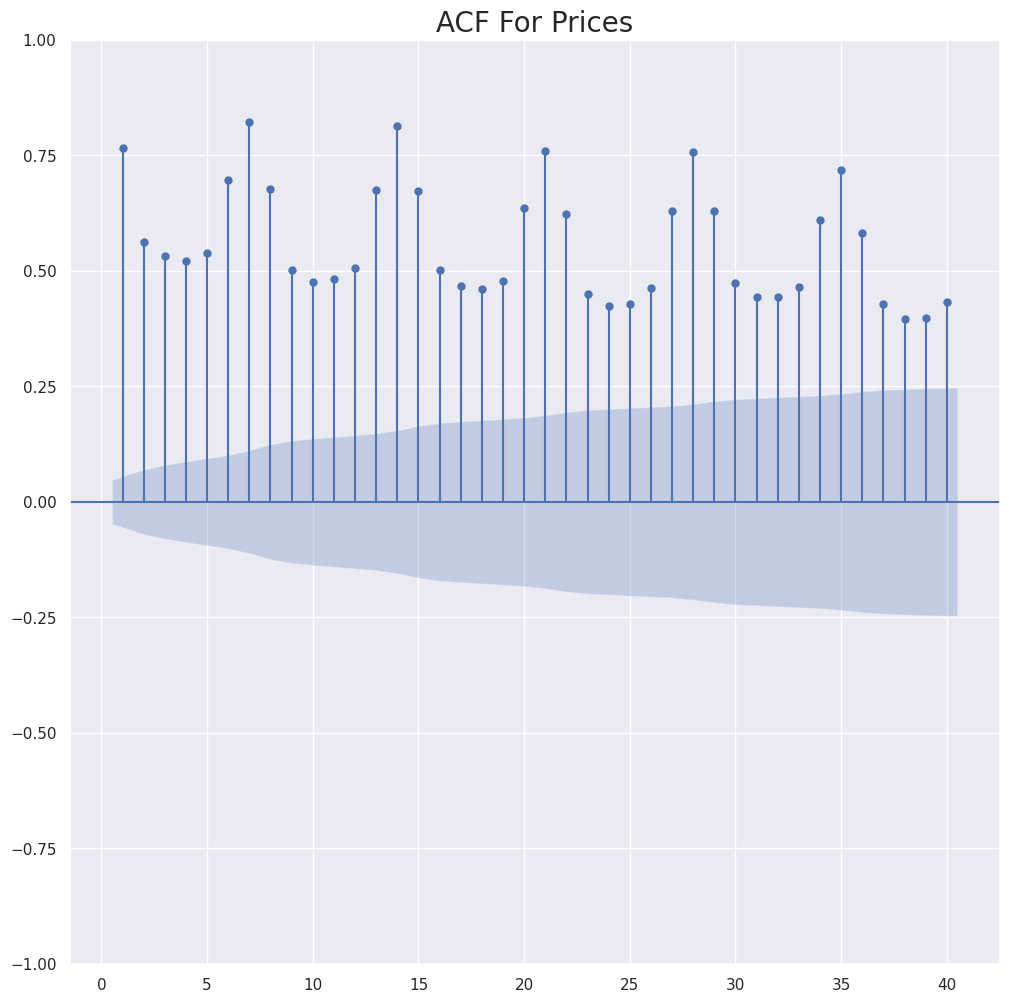

In [20]:
import statsmodels.graphics.tsaplots as sgt

sgt.plot_acf(train.groupby('date', as_index=False)['sales'].sum()['sales'], lags=40, zero=False)
plt.title("ACF For Prices", size=20)
plt.show()

#### Conclusion: 
- Dependence on weekends
- Need separate tests for Weekdays & Weeknends

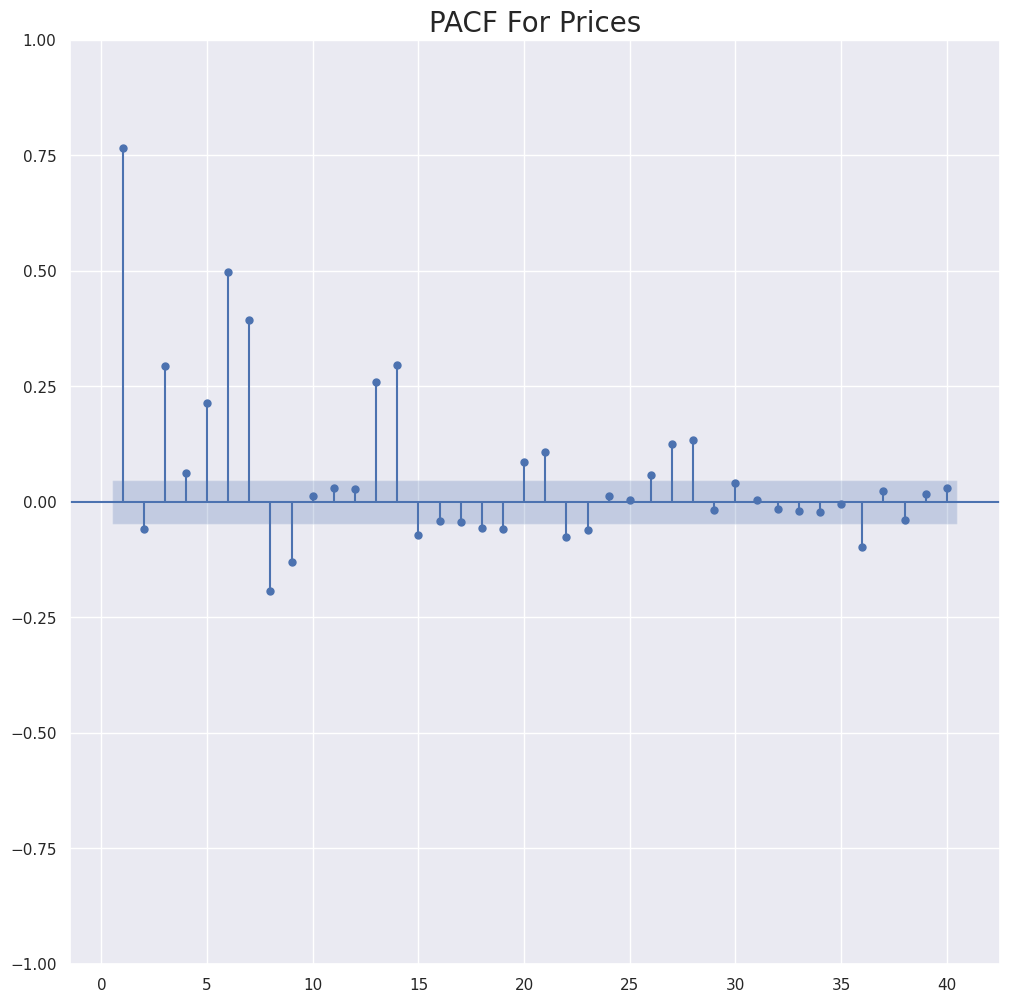

In [21]:
sgt.plot_pacf(train.groupby('date', as_index=False)['sales'].sum()['sales'], lags=40, zero=False, method='ols')
plt.title("PACF For Prices", size=20)
plt.show()

### Time Series of Total Sales after May 2017

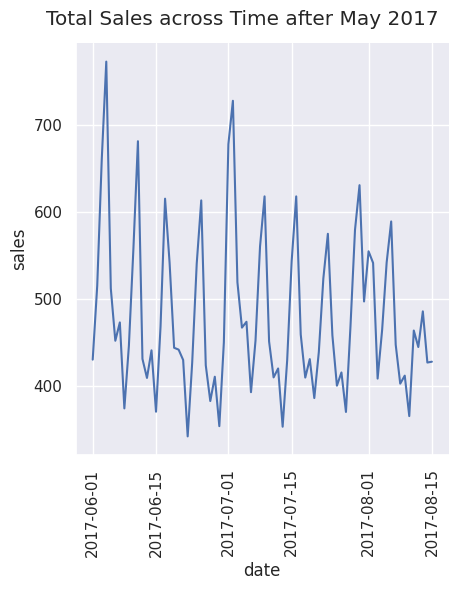

In [22]:
sns.set(rc={'figure.figsize':(12,12)})

resampled_data = train[train['date']>='2017-06-01']
g = sns.relplot(x="date", y="sales", data=resampled_data, kind="line", errorbar=None)

g.fig.suptitle("Total Sales across Time after May 2017", y=1.03)
plt.xticks(rotation=90)
plt.show()

## Last Date in Train

In [23]:
max(train['date'])

Timestamp('2017-08-15 00:00:00')

### Weekdays & Weekends

In [24]:
by_weekday = train.groupby(train['date'].dt.dayofweek)[['sales', 'onpromotion']].mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']


In [25]:
import numpy as np
weekend = np.where(train['date'].dt.weekday < 5, 'Weekday', 'Weekend')
by_weekend = train.groupby(weekend)[['sales', 'onpromotion']].mean()

by_weekend

,sales,onpromotion
Weekday,321.629081,2.831395
Weekend,448.179995,2.030972


### test.csv
- The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
- The dates in the test data are for the 15 days after the last date in the training data.

In [26]:
test = pd.read_csv('test.csv', parse_dates=['date'])
test.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
onpromotion             int64
dtype: object

In [27]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [28]:
test.groupby('store_nbr').count().describe()

,id,date,family,onpromotion
count,54.0,54.0,54.0,54.0
mean,528.0,528.0,528.0,528.0
std,0.0,0.0,0.0,0.0
min,528.0,528.0,528.0,528.0
25%,528.0,528.0,528.0,528.0
50%,528.0,528.0,528.0,528.0
75%,528.0,528.0,528.0,528.0
max,528.0,528.0,528.0,528.0


### Test data set is from 16th August to 31st August

### sample_submission.csv
- A sample submission file in the correct format.

### stores.csv
- Store metadata, including city, state, type, and cluster.
- cluster is a grouping of similar stores.

In [29]:
stores = pd.read_csv('stores.csv')
stores.dtypes

store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object

In [30]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [31]:
stores.shape

(54, 5)

In [32]:
stores.cluster.nunique()

17

In [33]:
stores.city.unique()

array(['Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba',
       'Ibarra', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil', 'Salinas',
       'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Cuenca',
       'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
      dtype=object)

In [34]:
stores.state.unique()

array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
       'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
       'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
       'Esmeraldas', 'Manabi'], dtype=object)

In [35]:
store_sales = train.merge(stores, how='left', left_on='store_nbr', right_on='store_nbr')

## Total Sales across Cluster

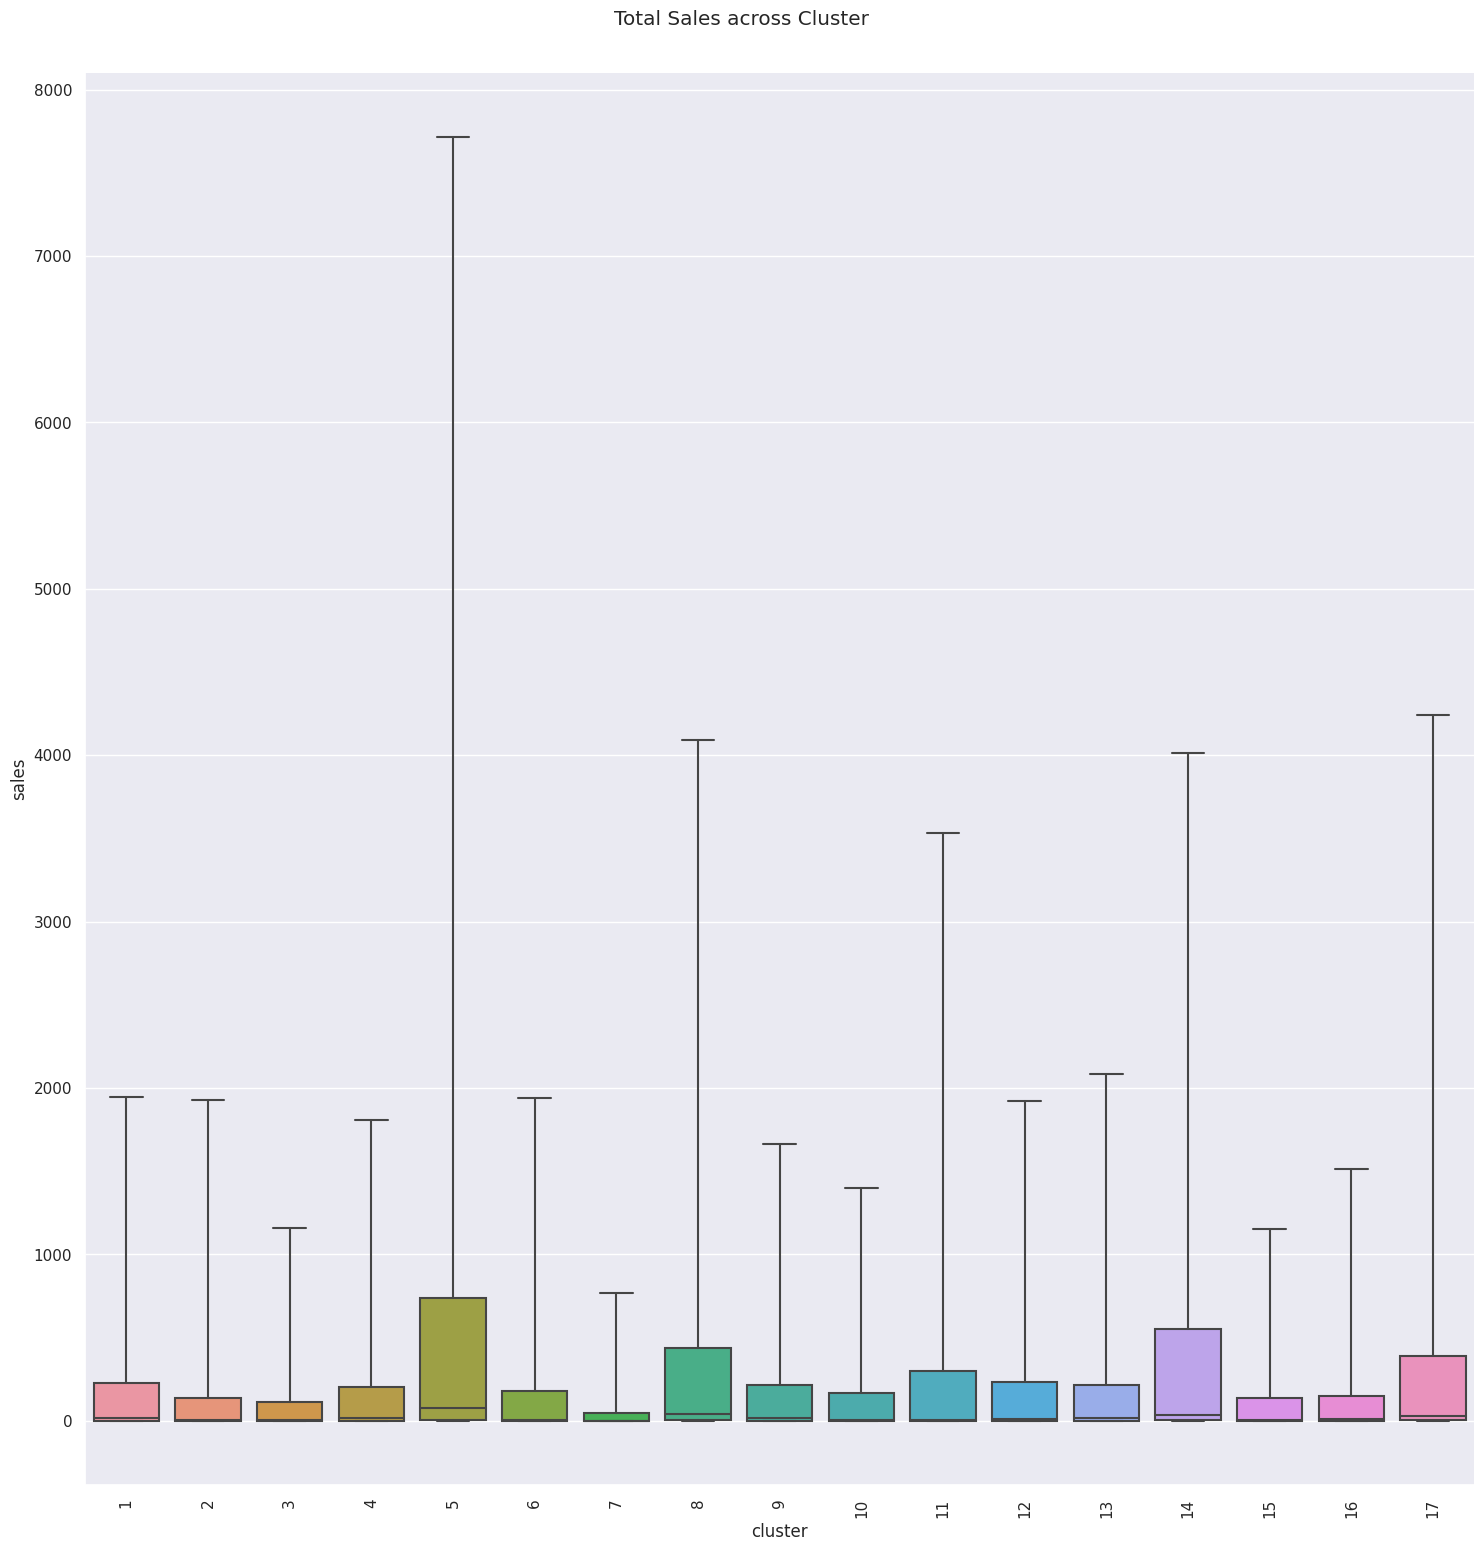

In [36]:
sns.set(rc={'figure.figsize':(20,20)})
g= sns.catplot(data=store_sales, x='cluster', y='sales', kind='box', whis=[5,95], sym="", height=15, aspect=1/1
            # col=year(date), 
            # col_wrap=3
           )

g.fig.suptitle("Total Sales across Cluster", y=1.03)
plt.xticks(rotation=90)
plt.show()

## Total Sales across Type

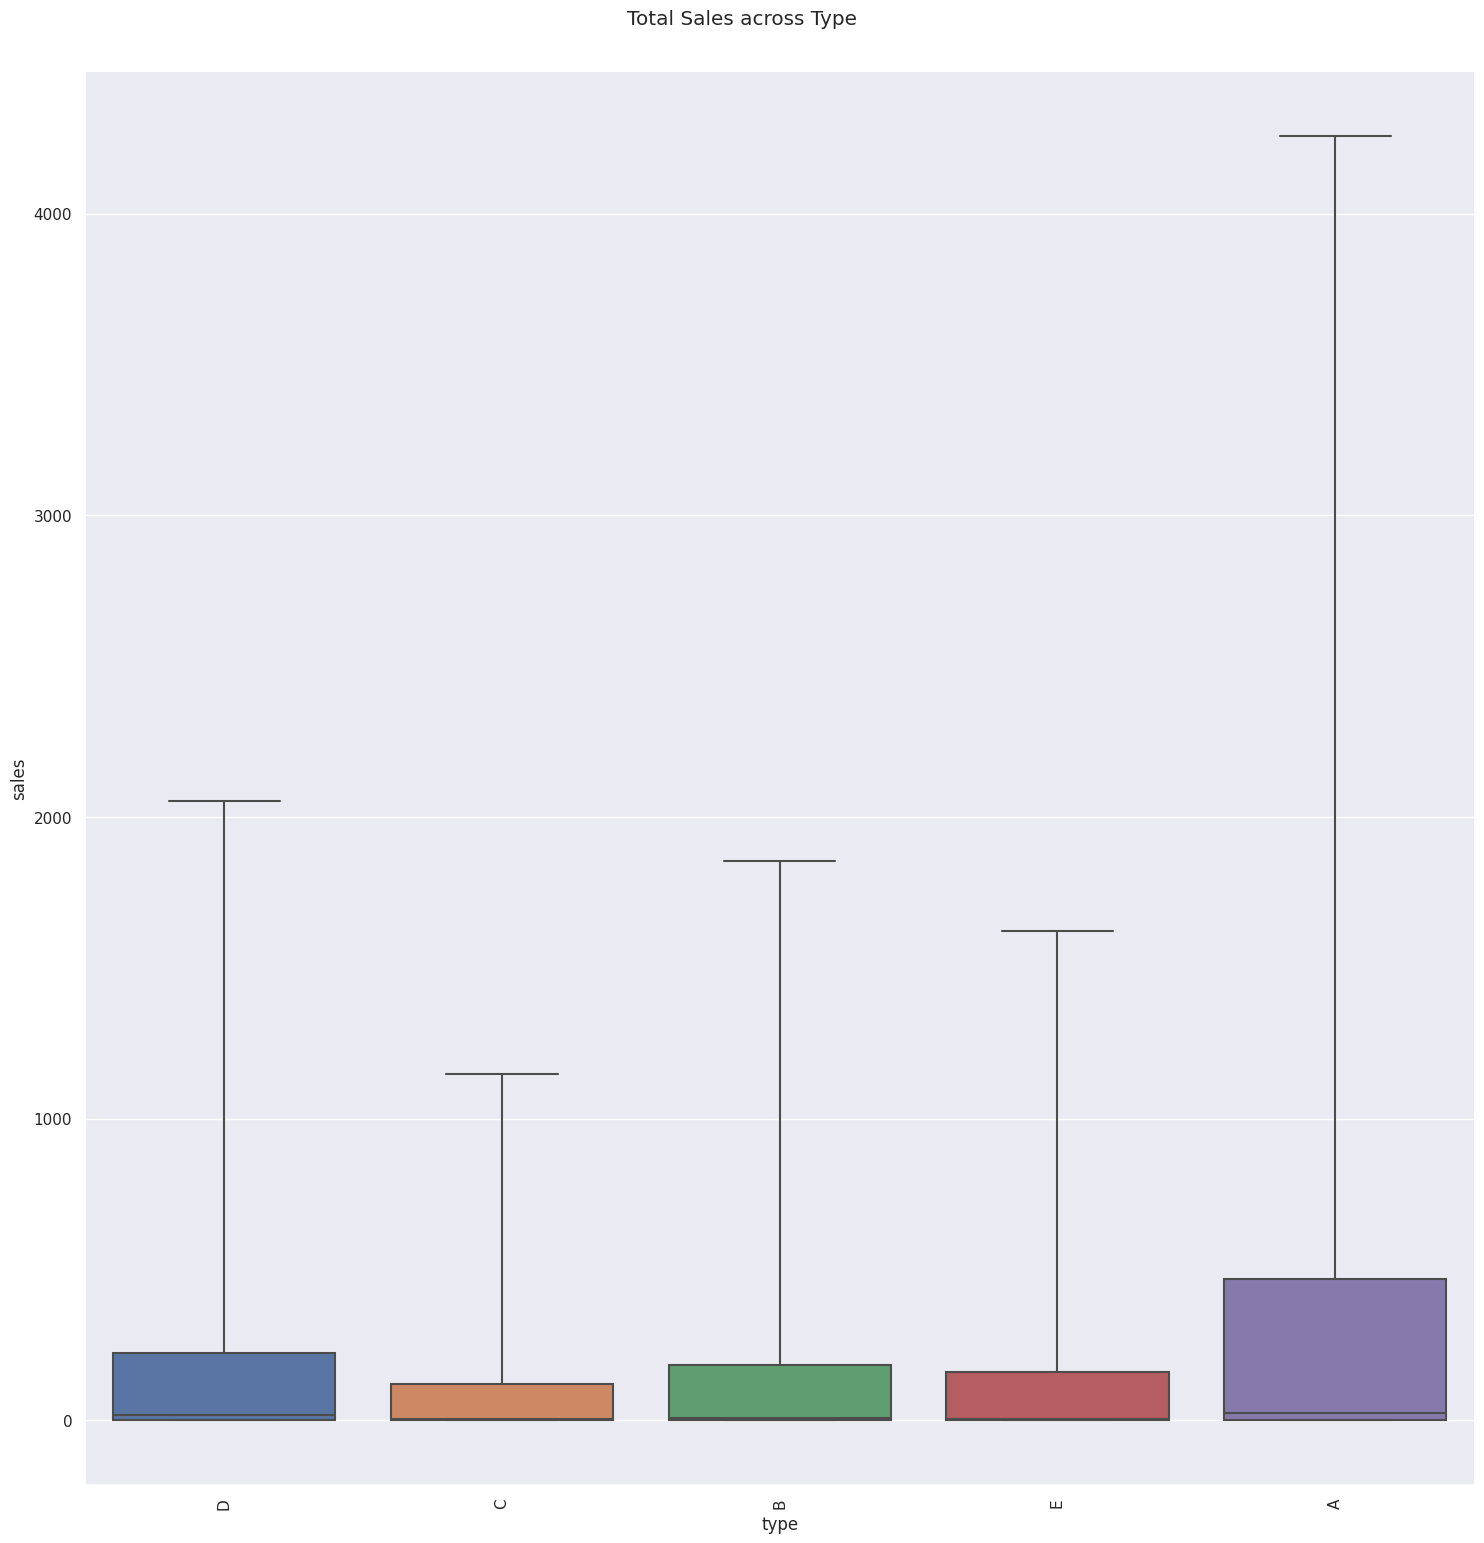

In [37]:
sns.set(rc={'figure.figsize':(20,20)})
g= sns.catplot(data=store_sales, x='type', y='sales', kind='box', whis=[5,95], sym="", height=15, aspect=1/1
            # col=year(date), 
            # col_wrap=3
           )

g.fig.suptitle("Total Sales across Type", y=1.03)
plt.xticks(rotation=90)
plt.show()

### oil.csv
- Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

In [38]:
oil = pd.read_csv('oil.csv', parse_dates=['date'])
oil.dtypes

date          datetime64[ns]
dcoilwtico           float64
dtype: object

In [39]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


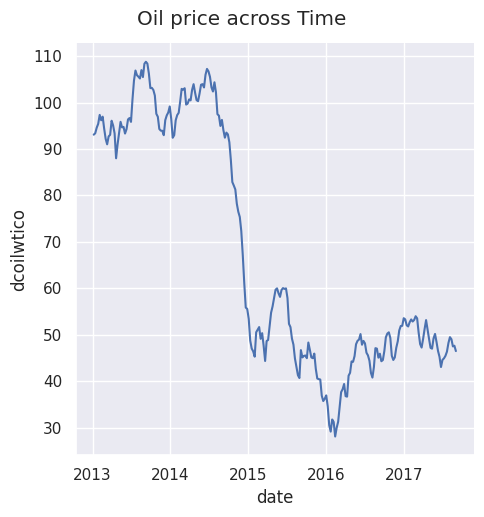

In [40]:
sns.set(rc={'figure.figsize':(12,12)})

resampled_data = oil.resample('W', on='date').mean()
g = sns.relplot(x="date", y="dcoilwtico", data=resampled_data, kind="line")

g.fig.suptitle("Oil price across Time", y=1.03)
plt.show()

### MIssing Days if Any

In [41]:
from datetime import date
import numpy as np

d0 = np.sort(oil['date'])[0]
d1 = np.sort(oil['date'])[-1]
delta = d1 - d0
no_of_days = oil['date'].nunique()
print('The number of days between the given range of dates is :')
print(delta.astype('timedelta64[D]')+1)
print(no_of_days)

The number of days between the given range of dates is :
1704 days
1218


In [42]:
d1

numpy.datetime64('2017-08-31T00:00:00.000000000')

### Find the missing Dates

In [43]:
pd.date_range(start=d0, end=d1).difference(oil['date'].unique())

DatetimeIndex(['2013-01-05', '2013-01-06', '2013-01-12', '2013-01-13',
               '2013-01-19', '2013-01-20', '2013-01-26', '2013-01-27',
               '2013-02-02', '2013-02-03',
               ...
               '2017-07-29', '2017-07-30', '2017-08-05', '2017-08-06',
               '2017-08-12', '2017-08-13', '2017-08-19', '2017-08-20',
               '2017-08-26', '2017-08-27'],
              dtype='datetime64[ns]', length=486, freq=None)

In [44]:
oil.set_index("date", inplace=True)
oil=oil.asfreq('d')
oil=oil.fillna(method='ffill')

#### Conclusion
- oil prices are unavailable on weekends
- Use ffill to fill oil prices for weekends

In [45]:
from datetime import date
import numpy as np

d0 = np.sort(oil.index)[0]
d1 = np.sort(oil.index)[-1]
delta = d1 - d0
no_of_days = oil.index.nunique()
print('The number of days between the given range of dates is :')
print(delta.astype('timedelta64[D]')+1)
print(no_of_days)

The number of days between the given range of dates is :
1704 days
1704


### Correlation between Oil & Sales

In [46]:
oil_sales = pd.DataFrame(train.groupby('date')['sales'].sum()).merge(oil, how='inner', left_index=True, right_index=True)

In [47]:
oil_sales.corr()

,sales,dcoilwtico
sales,1.000000,-0.626856
dcoilwtico,-0.626856,1.000000


#### Conclusion: Negative Correlation on oil prices and Sum of Sales on a given day

### holidays_events.csv

- Holidays and Events, with metadata
**NOTE**: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

- Additional Notes
 - Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
 - A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

In [48]:
holidays = pd.read_csv('holidays_events.csv', parse_dates=['date'])
holidays.dtypes

date           datetime64[ns]
type                   object
locale                 object
locale_name            object
description            object
transferred              bool
dtype: object

In [49]:
holidays.type.unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [50]:
holidays[holidays['description']=="Independencia de Guayaquil"]


,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
190,2015-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,False
274,2016-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,False
331,2017-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,False


### Event, Holidays that are not transferred, Additional & Bridge are marked as holidays

In [51]:
holidays['is_holiday'] = np.where((holidays['transferred']) | (holidays['type']=='Work Day') , 0, 1)

In [52]:
holidays[holidays['description']=="Independencia de Guayaquil"]


,date,type,locale,locale_name,description,transferred,is_holiday
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True,0
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True,0
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True,0
190,2015-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,False,1
274,2016-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,False,1
331,2017-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,False,1


In [53]:
locale_array = {}
for item in holidays.locale_name.unique():
    if item == 'Ecuador':
        locale_array[item]='All'
    elif item in stores.city.unique():
        locale_array[item]='City'
    elif item in stores.state.unique():
        locale_array[item]='State'
    else:
        locale_array[item]="None of the Above"

In [54]:
locale_array

{'Manta': 'City',
 'Cotopaxi': 'State',
 'Cuenca': 'City',
 'Libertad': 'City',
 'Riobamba': 'City',
 'Puyo': 'City',
 'Guaranda': 'City',
 'Imbabura': 'State',
 'Latacunga': 'City',
 'Machala': 'City',
 'Santo Domingo': 'City',
 'El Carmen': 'City',
 'Cayambe': 'City',
 'Esmeraldas': 'City',
 'Ecuador': 'All',
 'Ambato': 'City',
 'Ibarra': 'City',
 'Quevedo': 'City',
 'Santo Domingo de los Tsachilas': 'State',
 'Santa Elena': 'State',
 'Quito': 'City',
 'Loja': 'City',
 'Salinas': 'City',
 'Guayaquil': 'City'}

## Transactions

In [55]:
transactions = pd.read_csv('transactions.csv', parse_dates=['date'])
transactions.dtypes

date            datetime64[ns]
store_nbr                int64
transactions             int64
dtype: object

In [56]:
transactions.tail()

,date,store_nbr,transactions
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
83487,2017-08-15,54,802


### Dependence on Payday

In [57]:
payday = pd.read_csv('train.csv', parse_dates=['date'])
payday.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object

In [58]:
import datetime 
def is_payday(dt):
    todays_month = dt.month
    tomorrows_month = (dt + datetime.timedelta(days=1)).month
    return int((tomorrows_month != todays_month) | (dt.day==15))

In [59]:
payday['is_payday'] = payday['date'].apply(is_payday)

In [60]:
payday[payday['date']=='2013-01-31']

,id,date,store_nbr,family,sales,onpromotion,is_payday
53460,53460,2013-01-31,1,AUTOMOTIVE,0.000,0,1
53461,53461,2013-01-31,1,BABY CARE,0.000,0,1
53462,53462,2013-01-31,1,BEAUTY,2.000,0,1
53463,53463,2013-01-31,1,BEVERAGES,889.000,0,1
53464,53464,2013-01-31,1,BOOKS,0.000,0,1
...,...,...,...,...,...,...,...
55237,55237,2013-01-31,9,POULTRY,335.215,0,1
55238,55238,2013-01-31,9,PREPARED FOODS,42.000,0,1
55239,55239,2013-01-31,9,PRODUCE,0.000,0,1
55240,55240,2013-01-31,9,SCHOOL AND OFFICE SUPPLIES,0.000,0,1


# Building Simple Multiple Regression Model
- Build 1782 models 
- Model will depend on holiday(includes weekend), oil price & payday

In [61]:
df_train = pd.read_csv('train.csv', parse_dates=['date'])
import datetime 
def is_payday(dt):
    todays_month = dt.month
    tomorrows_month = (dt + datetime.timedelta(days=1)).month
    return int((tomorrows_month != todays_month) | (dt.day==15))

df_train['is_payday'] = df_train['date'].apply(is_payday)

df_train['is_weekend'] = np.where(df_train['date'].dt.weekday < 5, 0, 1)




df_train.head()

,id,date,store_nbr,family,sales,onpromotion,is_payday,is_weekend
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,0,0
2,2,2013-01-01,1,BEAUTY,0.0,0,0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,0,0
4,4,2013-01-01,1,BOOKS,0.0,0,0,0


In [62]:
df_holidays = pd.read_csv('holidays_events.csv', parse_dates=['date'])
df_holidays['is_holiday'] = np.where((df_holidays['transferred']) | (df_holidays['type']=='Work Day') , 0, 1)

df_holidays.head()

,date,type,locale,locale_name,description,transferred,is_holiday
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,1
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,1
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,1
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,1
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,1


In [63]:
df_oil = pd.read_csv('oil.csv', parse_dates=['date'])
df_oil.set_index("date", inplace=True)
df_oil=df_oil.asfreq('d')
df_oil=df_oil.fillna(method='ffill')

df_oil.reset_index(inplace=True)

df_oil=df_oil.fillna(method='bfill')

df_oil.head()

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.12


In [64]:
df_stores = pd.read_csv('stores.csv')

locale_array = {}
for item in df_holidays.locale_name.unique():
    if item == 'Ecuador':
        locale_array[item]=[item]
    elif item in stores.city.unique():
        locale_array[item]=[item]
    elif item in stores.state.unique():
        locale_array[item]=[item]
    else:
        locale_array[item]=[None]
        
def mapping_terr(place):
    if place not in locale_array:
        return ''
    else:
        return locale_array[place]



In [65]:
df_mapping_file = pd.DataFrame(locale_array)
df_mapping_file = df_mapping_file.transpose()

df_mapping_file.columns=['place']
df_mapping_file

,place
Manta,Manta
Cotopaxi,Cotopaxi
Cuenca,Cuenca
Libertad,Libertad
Riobamba,Riobamba
Puyo,Puyo
Guaranda,Guaranda
Imbabura,Imbabura
Latacunga,Latacunga
Machala,Machala


In [66]:
df_temp_2=df_stores.merge(df_mapping_file, how='left', left_on='city', right_index=True)
df_temp_2.head()

,store_nbr,city,state,type,cluster,place
0,1,Quito,Pichincha,D,13,Quito
1,2,Quito,Pichincha,D,13,Quito
2,3,Quito,Pichincha,D,8,Quito
3,4,Quito,Pichincha,D,9,Quito
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4,Santo Domingo


In [67]:
df_temp_3=df_stores.merge(df_mapping_file, how='left', left_on='state', right_index=True)
df_temp_3.head()

,store_nbr,city,state,type,cluster,place
0,1,Quito,Pichincha,D,13,NaN
1,2,Quito,Pichincha,D,13,NaN
2,3,Quito,Pichincha,D,8,NaN
3,4,Quito,Pichincha,D,9,NaN
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4,Santo Domingo de los Tsachilas


In [68]:
df_temp = df_stores
df_temp['place']='Ecuador'

df_store_mapping = pd.concat([df_temp_2, 
                              df_temp_3,
                              df_temp], ignore_index=True)

In [69]:
df_store_mapping = df_store_mapping[df_store_mapping['place'].notna()]


In [70]:
df_holidays_store = df_holidays[['date', 'is_holiday', 'locale_name']].merge(df_store_mapping,
                                                                             how='left',
                                                                             left_on='locale_name',
                                                                             right_on='place')

In [71]:
df_holidays_store = df_holidays_store[['date', 'is_holiday', 'store_nbr', 'cluster', 'type']]

df_holidays_store = df_holidays_store.groupby(['date', 'store_nbr', 'cluster', 'type'], as_index=False)['is_holiday'].sum()

df_holidays_store['is_holiday'] = np.where(df_holidays_store['is_holiday']==0, 0, 1)

In [72]:
df_holidays_store.head()

,date,store_nbr,cluster,type,is_holiday
0,2012-03-02,52,11,A,1
1,2012-03-02,53,13,D,1
2,2012-04-01,12,15,C,1
3,2012-04-01,13,15,C,1
4,2012-04-12,37,2,D,1


In [73]:
df_train_final = df_train.merge(df_holidays_store, how='left', left_on=['date', 'store_nbr'], right_on=['date', 'store_nbr']).merge(df_oil, left_on='date', right_on='date', how='left')

In [74]:
df_train_final.is_holiday = np.where(df_train_final.is_holiday.fillna(0)+df_train_final.is_weekend==0, 0, 1)

In [75]:
df_train_final = df_train_final.drop('is_weekend', axis=1)
df_train_final.head()

,id,date,store_nbr,family,sales,onpromotion,is_payday,cluster,type,is_holiday,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,13.0,D,1,93.14
1,1,2013-01-01,1,BABY CARE,0.0,0,0,13.0,D,1,93.14
2,2,2013-01-01,1,BEAUTY,0.0,0,0,13.0,D,1,93.14
3,3,2013-01-01,1,BEVERAGES,0.0,0,0,13.0,D,1,93.14
4,4,2013-01-01,1,BOOKS,0.0,0,0,13.0,D,1,93.14


In [76]:
df_train_final[df_train_final['date']=='2013-01-02']

,id,date,store_nbr,family,sales,onpromotion,is_payday,cluster,type,is_holiday,dcoilwtico
1782,1782,2013-01-02,1,AUTOMOTIVE,2.000,0,0,NaN,NaN,0,93.14
1783,1783,2013-01-02,1,BABY CARE,0.000,0,0,NaN,NaN,0,93.14
1784,1784,2013-01-02,1,BEAUTY,2.000,0,0,NaN,NaN,0,93.14
1785,1785,2013-01-02,1,BEVERAGES,1091.000,0,0,NaN,NaN,0,93.14
1786,1786,2013-01-02,1,BOOKS,0.000,0,0,NaN,NaN,0,93.14
...,...,...,...,...,...,...,...,...,...,...,...
3559,3559,2013-01-02,9,POULTRY,651.292,0,0,NaN,NaN,0,93.14
3560,3560,2013-01-02,9,PREPARED FOODS,83.000,0,0,NaN,NaN,0,93.14
3561,3561,2013-01-02,9,PRODUCE,0.000,0,0,NaN,NaN,0,93.14
3562,3562,2013-01-02,9,SCHOOL AND OFFICE SUPPLIES,0.000,0,0,NaN,NaN,0,93.14


In [77]:
df_train_final['cluster_A'] = np.where(df_train_final['cluster'].isin([5,8,11,14,17]), 1, 0)

df_train_final['type_A'] = np.where(df_train_final['type']=="A", 1, 0)

df_train_final = df_train_final.drop(['cluster', 'type'], axis=1)

df_train_final.head()

,id,date,store_nbr,family,sales,onpromotion,is_payday,is_holiday,dcoilwtico,cluster_A,type_A
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,1,93.14,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,0,1,93.14,0,0
2,2,2013-01-01,1,BEAUTY,0.0,0,0,1,93.14,0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,0,1,93.14,0,0
4,4,2013-01-01,1,BOOKS,0.0,0,0,1,93.14,0,0


## Training the model

In [78]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE

In [79]:
df_1_1 = df_train_final[(df_train_final['store_nbr']==1) & (df_train_final['family']=='AUTOMOTIVE')]
X = df_1_1[['onpromotion','is_payday','is_holiday', 'dcoilwtico' ]]
y = df_1_1['sales']

model=LinearRegression()
model.fit(X,y)


LinearRegression()

In [80]:
np.sqrt(MSE(y, model.predict(X)))

2.624737721808705

## ARIMA models

In [81]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [82]:
# model_auto = auto_arima(df_1_1.sales, exogenous=X,
#                       m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)

df_1_1 = df_train_final[(df_train_final['store_nbr']==1) & (df_train_final['family']=='BEVERAGES')]
        

X = df_1_1[['onpromotion','is_payday','is_holiday', 'dcoilwtico' , 'date', 'sales']]
X = X.set_index('date')
X = X.asfreq('D', method='bfill')
y = X['sales']
        
model = SARIMAX(y, exog=X[['onpromotion','is_payday','is_holiday', 'dcoilwtico']], order=(1,1,1),
                       seasonal_order=(1,0,1,7))
arima = model.fit(maxiter=100)



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.39147D+00    |proj g|=  1.78931D-01


 This problem is unconstrained.



At iterate    5    f=  7.33840D+00    |proj g|=  1.47011D-02

At iterate   10    f=  7.31571D+00    |proj g|=  9.20333D-03

At iterate   15    f=  7.28304D+00    |proj g|=  1.61722D-02

At iterate   20    f=  7.25541D+00    |proj g|=  7.17077D-03

At iterate   25    f=  7.25222D+00    |proj g|=  3.42643D-02

At iterate   30    f=  7.20795D+00    |proj g|=  6.57267D-02

At iterate   35    f=  7.14195D+00    |proj g|=  1.18924D-02

At iterate   40    f=  7.13196D+00    |proj g|=  1.83673D-03

At iterate   45    f=  7.13194D+00    |proj g|=  4.52825D-04

At iterate   50    f=  7.13178D+00    |proj g|=  4.92493D-03

At iterate   55    f=  7.13029D+00    |proj g|=  2.78744D-03

At iterate   60    f=  7.13018D+00    |proj g|=  1.05310D-03

At iterate   65    f=  7.13011D+00    |proj g|=  1.41022D-03

At iterate   70    f=  7.12943D+00    |proj g|=  2.43382D-03

At iterate   75    f=  7.12778D+00    |proj g|=  2.33011D-03

At iterate   80    f=  7.12772D+00    |proj g|=  1.33236D-04

At iter

/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot: xlabel='date'>

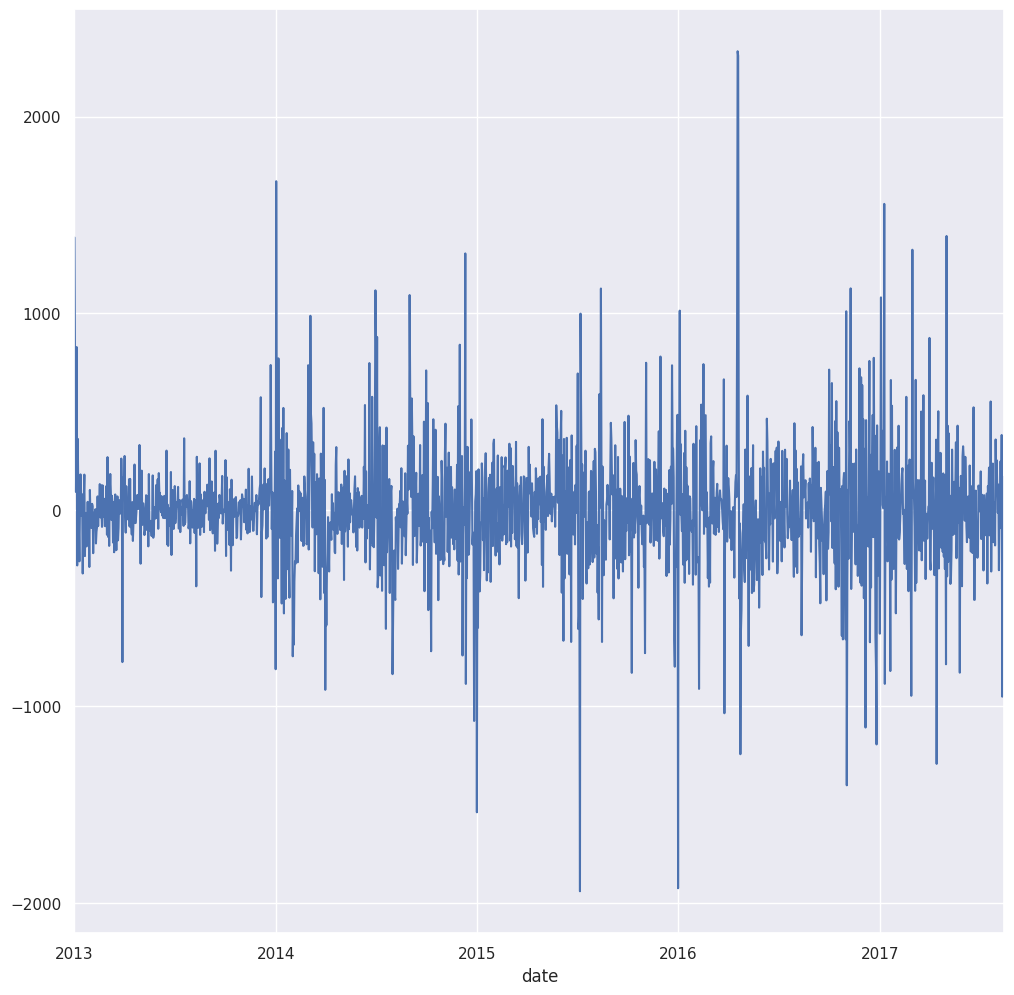

In [83]:
arima.resid.plot()

/home/akash/.local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


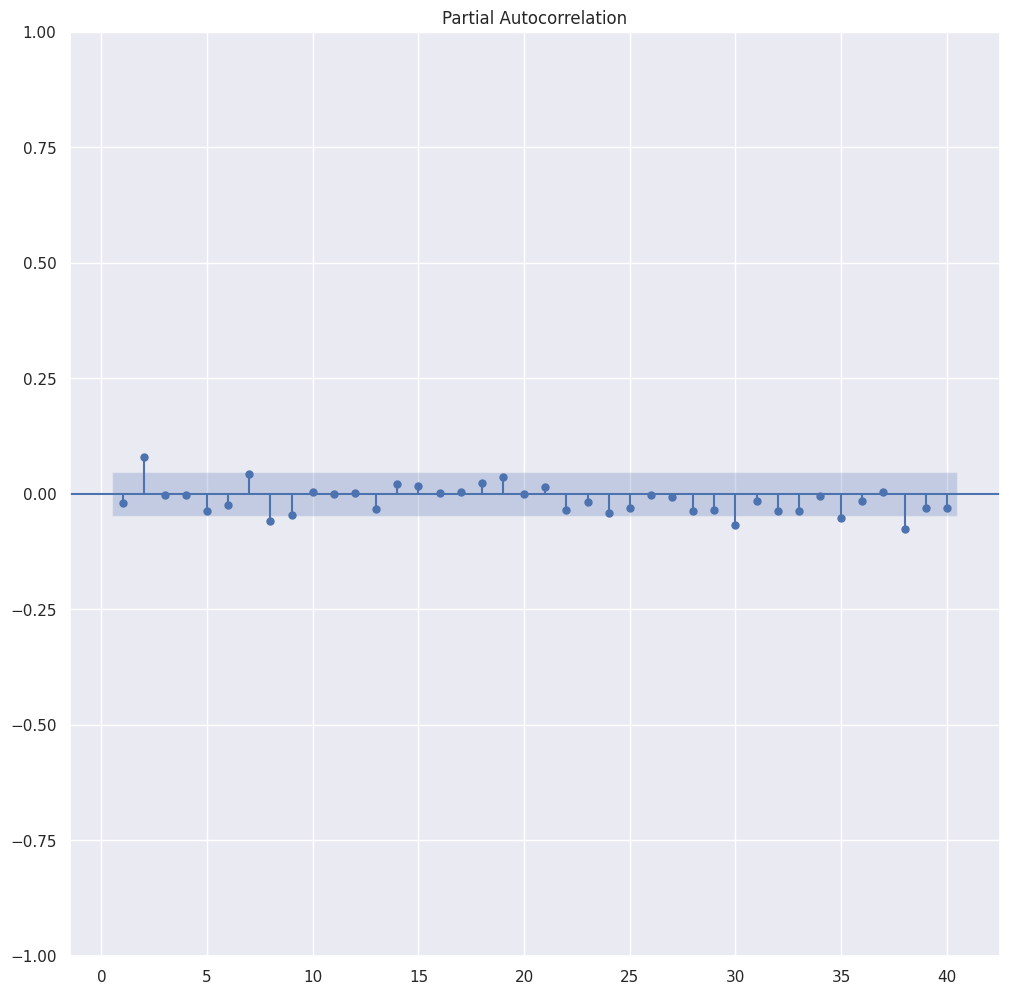

In [84]:
import statsmodels.graphics.tsaplots as sgt

sgt.plot_pacf(arima.resid, lags=40, zero=False)
plt.show()

## Random Forests

In [85]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=15, random_state=0)
regr.fit(X, y)


RandomForestRegressor(max_depth=15, random_state=0)

In [86]:
r2_score(y, regr.predict(X))

0.999863977866132

## Production ready predictions

### Making Test Set Ready

In [87]:
df_test = pd.read_csv('test.csv', parse_dates=['date'])
import datetime 
def is_payday(dt):
    todays_month = dt.month
    tomorrows_month = (dt + datetime.timedelta(days=1)).month
    return int((tomorrows_month != todays_month) | (dt.day==15))

df_test['is_payday'] = df_test['date'].apply(is_payday)

df_test['is_weekend'] = np.where(df_test['date'].dt.weekday < 5, 0, 1)



df_test.head()

,id,date,store_nbr,family,onpromotion,is_payday,is_weekend
0,3000888,2017-08-16,1,AUTOMOTIVE,0,0,0
1,3000889,2017-08-16,1,BABY CARE,0,0,0
2,3000890,2017-08-16,1,BEAUTY,2,0,0
3,3000891,2017-08-16,1,BEVERAGES,20,0,0
4,3000892,2017-08-16,1,BOOKS,0,0,0


In [88]:
df_test_final = df_test.merge(df_holidays_store, how='left', left_on=['date', 'store_nbr'], right_on=['date', 'store_nbr']).merge(df_oil, left_on='date', right_on='date', how='left')
df_test_final.is_holiday = np.where(df_test_final.is_holiday.fillna(0)+df_test_final.is_weekend==0, 0, 1)


df_test_final = df_test_final.drop('is_weekend', axis=1)

df_test_final['cluster_A'] = np.where(df_test_final['cluster'].isin([5,8,11,14,17]), 1, 0)

df_test_final['type_A'] = np.where(df_test_final['type']=="A", 1, 0)

df_test_final = df_test_final.drop(['cluster', 'type'], axis=1)
df_test_final.head()

,id,date,store_nbr,family,onpromotion,is_payday,is_holiday,dcoilwtico,cluster_A,type_A
0,3000888,2017-08-16,1,AUTOMOTIVE,0,0,0,46.8,0,0
1,3000889,2017-08-16,1,BABY CARE,0,0,0,46.8,0,0
2,3000890,2017-08-16,1,BEAUTY,2,0,0,46.8,0,0
3,3000891,2017-08-16,1,BEVERAGES,20,0,0,46.8,0,0
4,3000892,2017-08-16,1,BOOKS,0,0,0,46.8,0,0


In [89]:
df_test_final.tail()

,id,date,store_nbr,family,onpromotion,is_payday,is_holiday,dcoilwtico,cluster_A,type_A
28507,3029395,2017-08-31,9,POULTRY,1,1,0,47.26,0,0
28508,3029396,2017-08-31,9,PREPARED FOODS,0,1,0,47.26,0,0
28509,3029397,2017-08-31,9,PRODUCE,1,1,0,47.26,0,0
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,1,0,47.26,0,0
28511,3029399,2017-08-31,9,SEAFOOD,0,1,0,47.26,0,0


In [92]:
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


final_file = pd.DataFrame()
final_file_train = pd.DataFrame()

count = 0

df_train_final['date'] = df_train_final.date.dt.to_period('D')

for store_nbr in df_test_final.store_nbr.unique():
    for family in df_test_final.family.unique():
        df_1_1 = df_train_final[(df_train_final['store_nbr']==store_nbr) & (df_train_final['family']==family)].set_index('date')

        X = df_1_1[['onpromotion','is_payday','is_holiday', 'dcoilwtico']]
        y = df_1_1['sales']
        
        fourier = CalendarFourier(freq='M', order=4)
        dp = DeterministicProcess(
            index=y.index,
            constant=True,
            order=1,
            seasonal=True,
            additional_terms=[fourier],
            drop=True,
        )
        X = pd.concat([X, dp.in_sample()], axis=1)

        regr = RandomForestRegressor(max_depth=15, random_state=0)
        regr.fit(X, y)


        
        test = df_test_final[(df_test_final['store_nbr']==store_nbr) & (df_test_final['family']==family)].set_index('date')
        out = dp.out_of_sample(16)
        out.index = out.index.astype(np.datetime64)
        
        test_1 = pd.concat([test[['onpromotion','is_payday','is_holiday', 'dcoilwtico' ]], out], axis=1)
        
        new = pd.concat([test.id, pd.Series(regr.predict(test_1), 
                                            index=test.index)],axis=1)
        
        new_2 = pd.concat([df_1_1.id, pd.Series(regr.predict(X), 
                                            index=df_1_1.index)],axis=1)
        
        final_file = pd.concat([final_file, new])
        
        final_file_train = pd.concat([final_file_train, new_2])
        
        count +=1
        print(count)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
final_file.sort_index().to_csv('submission_9.csv', index=False, header=['id', 'sales'])

In [98]:
final_file = final_file.sort_index()
final_file.columns=['id', 'pred_sales']

In [99]:
final_file_train = final_file_train.sort_index()
final_file_train.columns=['id', 'pred_sales']

In [100]:
df_train_final.date = df_train_final.date.astype(np.datetime64)
df_train_final_arima = pd.concat([df_train_final.merge(final_file_train, on='id'),
                                  df_test_final.merge(final_file, on='id')])

/tmp/ipykernel_26008/3973444680.py:1: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  df_train_final.date = df_train_final.date.astype(np.datetime64)


## Prediction for Store no 1 and Grocery I

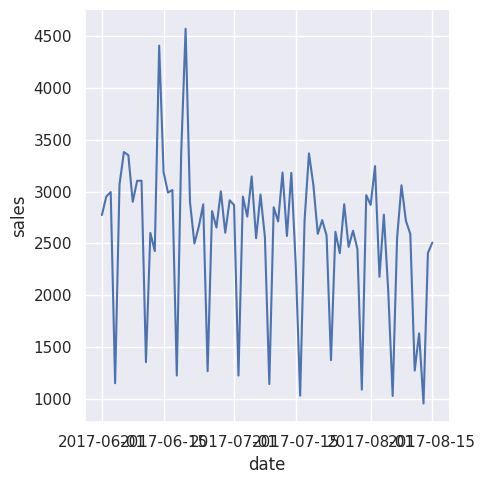

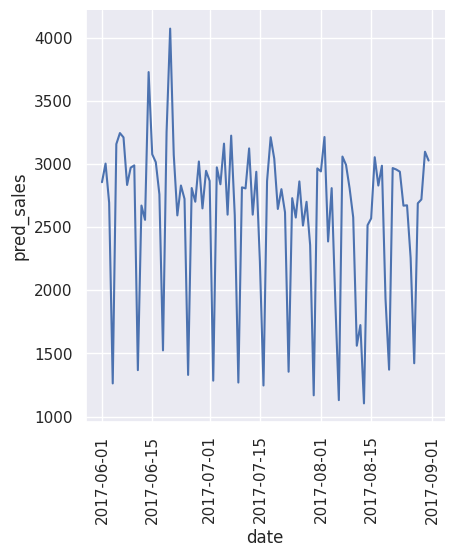

In [96]:
sns.set(rc={'figure.figsize':(20,20)})
sns.relplot(data=df_train_final_arima[(df_train_final_arima['store_nbr']==1) & (df_train_final_arima['family']=='GROCERY I') & (df_train_final_arima['date']>='2017-06-01')] ,
            x='date',
            y='sales',
            kind='line')

sns.relplot(data=df_train_final_arima[(df_train_final_arima['store_nbr']==1) & (df_train_final_arima['family']=='GROCERY I') & (df_train_final_arima['date']>='2017-06-01')] ,
            x='date',
            y='pred_sales',
            kind='line')

plt.xticks(rotation=90)
plt.show()

In [ ]:
final_file = pd.read_csv('submission_9.csv')

In [111]:
df_train_final_arima[df_train_final_arima['sales'].isna()]

,id,date,store_nbr,family,sales,onpromotion,is_payday,is_holiday,dcoilwtico,cluster_A,type_A,pred_sales
0,3000888,2017-08-16,1,AUTOMOTIVE,NaN,0,0,0,46.80,0,0,4.541213
1,3000889,2017-08-16,1,BABY CARE,NaN,0,0,0,46.80,0,0,0.000000
2,3000890,2017-08-16,1,BEAUTY,NaN,2,0,0,46.80,0,0,6.359286
3,3000891,2017-08-16,1,BEVERAGES,NaN,20,0,0,46.80,0,0,2372.920926
4,3000892,2017-08-16,1,BOOKS,NaN,0,0,0,46.80,0,0,0.270000
...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,NaN,1,1,0,47.26,0,0,397.855408
28508,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,1,0,47.26,0,0,107.836740
28509,3029397,2017-08-31,9,PRODUCE,NaN,1,1,0,47.26,0,0,1377.046379
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,1,0,47.26,0,0,107.830000


In [130]:
x= arima.predict(exog=df_1_1[df_1_1['date']>=start_date][['onpromotion', 'pred_sales']],
                                                         start=start_date, end=end_date)
x.index=test.index
x

62       559.206749
1844     273.990637
3626     262.180015
5408     405.820188
7190     400.861286
8972     341.894202
10754    458.157708
12536    272.250567
14318    274.941952
16100    266.703640
17882    345.369639
19664    362.569852
21446    317.582905
23228    439.545447
25010    418.495211
26792    296.902951
Name: predicted_mean, dtype: float64

In [134]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

final_file_1 = pd.DataFrame()
count = 0

# df_train_final_arima = pd.concat([df_train_final, df_test_final.merge(final_file, on='id')])

for store_nbr in df_test_final.store_nbr.unique():
    for family in df_test_final.family.unique():
        df_1_1 = df_train_final_arima[(df_train_final_arima['store_nbr']==store_nbr) & (df_train_final_arima['family']==family)]
        
#         df_1_1 = df_1_1.asfreq('D', method='bfill')
#         df_1_1['shifted_by_week'] = df_1_1.shift(periods=-7, freq="D") 
        
#         df_1_1.reset_index()

        start_date='2017-08-16'
        end_date='2017-08-31'
        
        X = df_1_1[df_1_1['date']<start_date][['onpromotion', 'dcoilwtico' , 'date', 'pred_sales', 'sales']]
        X = X.set_index('date')
        X = X.asfreq('D', method='bfill')
        y = X['sales']
        
        model = SARIMAX(y, exog=X[['onpromotion', 'pred_sales']], order=(1,1,1),
                       seasonal_order=(2,0,0,7))
        arima = model.fit(maxiter=50, disp=False)

        
        test = df_test_final[(df_test_final['store_nbr']==store_nbr) & (df_test_final['family']==family)]
        
# #         test = test.asfreq('D', method='bfill')
# #         test['shifted_by_week'] = test.shift(periods=-7, freq="D") 
        
# #         df_1_1.reset_index()
        
        
        
        test = test.set_index('date')        
        test = test.asfreq('D', method='bfill')
        
        new = pd.concat([test.id, pd.Series(arima.predict(exog=df_1_1[df_1_1['date']>=start_date][['onpromotion', 'pred_sales']],
                                                         start=start_date, end=end_date), 
                                            index=test.index)],axis=1)
        final_file_1 = pd.concat([final_file_1, new])
        
        count +=1
        print(count)

1


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2
3
4
5
6
7


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


71
72
73
74
75
76
77
78


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


79
80
81
82
83
84


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


85
86
87
88
89
90
91


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


92
93
94
95
96
97
98
99
100


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


101
102
103


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


134
135
136


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


137
138
139
140
141
142
143
144


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


170
171
172
173
174
175
176
177


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


178
179
180
181
182
183
184
185


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


186
187


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


188
189
190
191
192
193
194
195
196
197
198
199
200
201
202


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


203
204
205


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


236
237
238
239
240
241
242


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


243
244
245
246
247
248
249
250


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


251


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


287
288
289
290
291
292
293
294
295


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


296
297
298
299
300
301


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


334


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


335
336
337


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


374
375


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


400


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427


/home/akash/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/akash/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


428
429
430
431
432
433


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


483
484
485
486
487
488
489
490
491
492
493
494
495
496


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


497
498
499
500
501
502


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


503
504
505
506


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


507
508
509
510
511
512
513
514
515
516
517


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


551
552
553
554
555
556
557
558
559
560
561
562
563
564


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


565
566
567
568
569
570
571
572
573


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


574
575
576
577
578
579
580


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


599
600
601
602


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


603
604
605
606


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


631
632


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


633
634


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


635
636
637
638
639


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


640
641
642
643
644
645
646
647


/home/akash/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


648
649
650
651
652
653
654
655
656
657
658
659
660
661


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


662
663
664


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


665
666
667
668
669
670
671
672


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


673
674
675
676
677
678
679


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


697


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


698
699
700
701
702
703
704
705
706
707
708
709
710
711
712


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


730
731


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


732
733
734


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


735
736
737
738


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


739
740
741
742
743
744
745
746
747
748
749
750
751


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


752
753
754
755
756


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


757
758
759
760
761
762
763


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


780
781


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


782
783
784
785
786
787
788
789
790
791
792
793
794
795
796


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


797
798
799
800
801
802
803
804


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


830
831
832
833
834
835


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


836


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


837
838
839
840
841
842
843
844


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


845


/home/akash/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/akash/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


863
864
865
866
867
868
869
870


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


871
872
873
874
875
876
877


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


878


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


929
930
931
932
933
934
935
936


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


937
938
939
940
941
942
943


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


944
945
946


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


947
948
949
950
951
952
953
954
955
956
957
958
959
960
961


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


998
999
1000
1001
1002


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1035


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1036
1037
1038
1039
1040
1041
1042
1043
1044
1045


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1046
1047
1048
1049
1050
1051
1052
1053
1054


/home/akash/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/akash/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


1055
1056
1057
1058
1059
1060


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1061
1062
1063
1064
1065
1066


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1067
1068


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1081
1082
1083
1084
1085
1086
1087
1088
1089
1090


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1102
1103
1104
1105
1106
1107
1108
1109
1110
1111


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1127
1128
1129
1130
1131
1132
1133
1134


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1135
1136
1137
1138
1139
1140
1141


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1226
1227
1228
1229
1230
1231
1232
1233


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1234
1235
1236
1237
1238
1239
1240


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1256
1257


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1258
1259


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1260
1261
1262


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1263
1264
1265
1266


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1285
1286
1287
1288


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1289
1290


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1291
1292
1293
1294


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1295
1296
1297


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1298


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1299


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1317
1318
1319
1320
1321


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1322
1323


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1324
1325
1326
1327
1328
1329
1330
1331
1332


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1333
1334
1335
1336
1337
1338


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1350
1351
1352
1353
1354


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1355
1356
1357
1358
1359
1360


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1361
1362
1363
1364


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1365


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1383
1384
1385
1386
1387


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1388
1389


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1390
1391
1392
1393
1394


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1395
1396


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1397
1398


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1399
1400
1401
1402
1403
1404
1405
1406
1407
1408


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1409
1410
1411


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1412
1413
1414
1415


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1416
1417
1418
1419
1420


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1421
1422


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1423
1424
1425
1426
1427
1428
1429
1430
1431


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1432
1433
1434
1435
1436
1437
1438
1439
1440
1441


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1442
1443
1444
1445
1446
1447
1448
1449


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1450
1451
1452
1453


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1487
1488
1489
1490
1491
1492


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1493
1494
1495


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1496
1497


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1531
1532
1533
1534
1535
1536
1537
1538
1539
1540


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1541
1542
1543


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1544
1545
1546


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1547
1548
1549
1550
1551
1552


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1553
1554


/home/akash/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


1555


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1556
1557
1558
1559
1560
1561
1562
1563


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1621


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1622


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1637


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1638
1639


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1662


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1663
1664
1665
1666
1667
1668
1669
1670
1671
1672


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1673
1674


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1720
1721
1722
1723


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1724
1725
1726
1727


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1728


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1729
1730
1731
1732
1733
1734
1735
1736
1737
1738


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1739
1740


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1753


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1754


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1755
1756
1757
1758
1759
1760
1761


/home/akash/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782


In [136]:
final_file_1.columns=['id', 'sales']
final_file_2 = final_file_1.clip(0.0)

In [138]:
final_file_2.sort_values(by='id').to_csv('submission_11.csv', index=False, header=['id', 'sales'])